In [1]:
from glob import glob
import re
import shutil

import numpy as np
import pandas as pd
import dask.dataframe as dpd
import dask
import zarr
import xarray as xr
from tqdm import tqdm

In [2]:
ddir = '/rigel/ocp/users/csj2114/swot/agulhas/run_1week_fwd'
fnames = sorted(glob(f'{ddir}/*.csv'))
fnames[:4]

['/rigel/ocp/users/csj2114/swot/agulhas/run_1week_fwd/float_trajectories.0000000000.001.001.csv',
 '/rigel/ocp/users/csj2114/swot/agulhas/run_1week_fwd/float_trajectories.0000000000.001.002.csv',
 '/rigel/ocp/users/csj2114/swot/agulhas/run_1week_fwd/float_trajectories.0000000000.001.003.csv',
 '/rigel/ocp/users/csj2114/swot/agulhas/run_1week_fwd/float_trajectories.0000000000.001.004.csv']

In [3]:
ddir_back = '/rigel/ocp/users/csj2114/swot/agulhas/run_1week_back'
fnames_back = sorted(glob(f'{ddir_back}/*.csv'))
fnames_back[:4]

['/rigel/ocp/users/csj2114/swot/agulhas/run_1week_back/float_trajectories.0000000000.001.001.csv',
 '/rigel/ocp/users/csj2114/swot/agulhas/run_1week_back/float_trajectories.0000000000.001.002.csv',
 '/rigel/ocp/users/csj2114/swot/agulhas/run_1week_back/float_trajectories.0000000000.001.003.csv',
 '/rigel/ocp/users/csj2114/swot/agulhas/run_1week_back/float_trajectories.0000000000.001.004.csv']

In [4]:
pattern = '.*\.(\d{10})\.(\d{3})\.(\d{3})\.csv'
r = re.compile(pattern)
file_data = np.array(
    [(int(m.group(1)), int(m.group(2)), int(m.group(3)))
     for m in map(r.match, fnames)]
)
niters, ntile_x, ntile_y = file_data.transpose()
niter_unique = np.unique(niters)
len(niter_unique)

169

In [5]:
pattern = '.*\.(\d{10})\.(\d{3})\.(\d{3})\.csv'
r = re.compile(pattern)
file_data_back = np.array(
    [(int(m.group(1)), int(m.group(2)), int(m.group(3)))
     for m in map(r.match, fnames_back)]
)
niters_b, ntile_xb, ntile_yb = file_data_back.transpose()
niter_uniqueb = np.unique(niters_b)
len(niter_uniqueb)

169

In [6]:
def timestep_to_ds_eager(ddir, niter, num_particles):
    """
    Read CSV files for one timestep and turn into an xarray dataset.
    This function is *eager*, loading the data into memory at the beginning.
    """
    niter_abs = abs(niter)
    fnames = sorted(glob(f'{ddir}/float_trajectories.{niter_abs:010d}.*.csv'))
    df = dpd.read_csv(fnames)
    
    # load it all into memory
    df = df.compute()
    df = df.drop('time', axis=1)
    
    # much faster than dask for small dataframes
    df = df.set_index('npart')
    
    npart_expected = np.arange(1, num_particles+1)
    df = df.reindex(npart_expected)
    
    ds = df.to_xarray()
    ds = ds.expand_dims('niter', axis=0)
    ds.coords['niter'] = ('niter', [niter])

    return ds

In [7]:
target = '/rigel/ocp/users/csj2114/swot/agulhas/run_1week.zarr'
niter_fb = np.concatenate([-niter_uniqueb[:0:-1], niter_unique])
num_particles = 4665600

In [8]:
#%%time 
for n in tqdm(niter_fb):
    if n<0:
        ds = timestep_to_ds_eager(ddir_back, n, num_particles)
    else:
        ds = timestep_to_ds_eager(ddir, n, num_particles)
    ds.chunk().to_zarr(target, append_dim='niter')

100%|██████████| 337/337 [2:01:44<00:00, 21.68s/it]


In [2]:
%matplotlib inline
import os
import dask.dataframe as dd
import pandas as pd
import xarray as xr
#from floater.generators import FloatSet
from glob import glob
from tqdm import tqdm
import numpy as np
import zarr

In [3]:
test = zarr.open('/rigel/ocp/users/csj2114/swot/agulhas/run_1week.zarr')

In [8]:
test2=xr.open_zarr('/rigel/ocp/users/csj2114/swot/agulhas/run_1week.zarr')

In [12]:
test2

<xarray.Dataset>
Dimensions:  (niter: 337, npart: 4665600)
Coordinates:
  * niter    (niter) int64 -24192 -24048 -23904 -23760 ... 23904 24048 24192
  * npart    (npart) int64 1 2 3 4 5 ... 4665596 4665597 4665598 4665599 4665600
Data variables:
    eta      (niter, npart) float64 dask.array<chunksize=(1, 4665600), meta=np.ndarray>
    s        (niter, npart) float64 dask.array<chunksize=(1, 4665600), meta=np.ndarray>
    t        (niter, npart) float64 dask.array<chunksize=(1, 4665600), meta=np.ndarray>
    u        (niter, npart) float64 dask.array<chunksize=(1, 4665600), meta=np.ndarray>
    v        (niter, npart) float64 dask.array<chunksize=(1, 4665600), meta=np.ndarray>
    x        (niter, npart) float64 dask.array<chunksize=(1, 4665600), meta=np.ndarray>
    y        (niter, npart) float64 dask.array<chunksize=(1, 4665600), meta=np.ndarray>
    z        (niter, npart) float64 dask.array<chunksize=(1, 4665600), meta=np.ndarray>

In [13]:
from rechunker import rechunk

In [14]:
source = zarr.open('/rigel/ocp/users/csj2114/swot/agulhas/run_1week.zarr')
intermediate = f'/rigel/ocp/users/csj2114/swot/agulhas/intermediate.zarr'
target = f'/rigel/ocp/users/csj2114/swot/agulhas/run_1week_rechunked.zarr'

In [24]:
r = rechunk(source, target_chunks={'eta':{'niter': 337, 'npart': 32400},
                                   's':{'niter': 337, 'npart': 32400},
                                   't':{'niter': 337, 'npart': 32400},
                                   'u':{'niter': 337, 'npart': 32400},
                                   'v':{'niter': 337, 'npart': 32400},
                                   'x':{'niter': 337, 'npart': 32400},
                                   'y':{'niter': 337, 'npart': 32400},
                                   'z':{'niter': 337, 'npart': 32400},
                                   'niter':None,
                                   'npart':None
                                  }, max_mem='1GB',
            target_store=target, temp_store=intermediate, executor='dask')
r

<Rechunked>
* Source      : <zarr.hierarchy.Group '/'>

* Intermediate: <zarr.hierarchy.Group '/'>

* Target      : <zarr.hierarchy.Group '/'>

In [18]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(service_kwargs={'dashboard': {'prefix': '/foo'}})
client = Client(cluster)

In [28]:
cluster.close()
#client

In [25]:
r.execute()

<zarr.hierarchy.Group '/'>

In [26]:
newtest = xr.open_zarr('/rigel/ocp/users/csj2114/swot/agulhas/run_1week_rechunked.zarr')

In [27]:
newtest

<xarray.Dataset>
Dimensions:  (niter: 337, npart: 4665600)
Coordinates:
  * niter    (niter) int64 -24192 -24048 -23904 -23760 ... 23904 24048 24192
  * npart    (npart) int64 1 2 3 4 5 ... 4665596 4665597 4665598 4665599 4665600
Data variables:
    eta      (niter, npart) float64 dask.array<chunksize=(337, 32400), meta=np.ndarray>
    s        (niter, npart) float64 dask.array<chunksize=(337, 32400), meta=np.ndarray>
    t        (niter, npart) float64 dask.array<chunksize=(337, 32400), meta=np.ndarray>
    u        (niter, npart) float64 dask.array<chunksize=(337, 32400), meta=np.ndarray>
    v        (niter, npart) float64 dask.array<chunksize=(337, 32400), meta=np.ndarray>
    x        (niter, npart) float64 dask.array<chunksize=(337, 32400), meta=np.ndarray>
    y        (niter, npart) float64 dask.array<chunksize=(337, 32400), meta=np.ndarray>
    z        (niter, npart) float64 dask.array<chunksize=(337, 32400), meta=np.ndarray>

In [22]:
newtest.isel(niter=0).plot.scatter(x='x',y='y',hue='npart')

ValueError: hue must be one of (t, u, x, y, eta, z, v, s, niter)

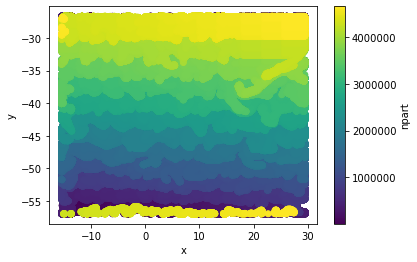

In [4]:
test.isel(niter=0).plot.scatter(x='x',y='y',hue='npart')

In [6]:
input_dir='/rigel/ocp/users/csj2114/swot/agulhas/run_1week_back'
float_file_prefix = 'float_trajectories'

In [7]:
match_pattern = float_file_prefix + '.*.csv'
float_files = glob(os.path.join(input_dir, match_pattern))
float_header = pd.read_csv(float_files[0], nrows=0).columns
float_timesteps = sorted(list({int(float_file[-22:-12]) for float_file in float_files}))
float_columns = ['npart', 'time', 'x', 'y', 'z', 'u', 'v','t','s','eta']

ref_time = '2000-01-01'

In [27]:
input_path =os.path.join(input_dir, '%s.000000*.csv' % float_file_prefix)
df = dd.read_csv(input_path, names=float_columns,header=0)#, memory_map=True)

In [28]:
df.sort_values(by=['time', 'npart'])

AttributeError: 'DataFrame' object has no attribute 'sort_values'

In [8]:
# the old way is good for loading individual time slices
for float_timestep in tqdm(float_timesteps[0:2]):
    input_path = os.path.join(input_dir, '%s.%010d.*.csv' % (float_file_prefix, float_timestep))
    if float_header[0] != 'npart':
        df = dd.read_csv(input_path, names=float_columns, header=None)
    else:
        df = dd.read_csv(input_path)
    dfc = df.compute()
    dfcs = dfc.sort_values('npart')
    del_time = int(dfcs.time.values[0])
    if ref_time is not None:
        ref_time = np.datetime64(ref_time, 'ns')
        del_time = np.timedelta64(del_time, 's')
        time = np.array([ref_time+del_time])
    else:
        time = np.array([np.int32(del_time)])
    npart = dfcs.npart.values.astype(np.int64)
    var_shape = (1, len(npart))
    var_names = dfcs.columns[2:]
    data_vars = {var_name: (['time', 'npart'], dfcs[var_name].values.astype(np.float64).reshape(var_shape)) for var_name in var_names}
    ds = xr.Dataset(data_vars, coords={'time': time, 'npart': npart})
    if float_timestep == float_timesteps[0]:
        ds_merged = ds
    else:
        ds_merged = xr.concat([ds_merged, ds], dim='time')

100%|██████████| 2/2 [01:13<00:00, 36.61s/it]


In [5]:
sorted = dfcs.npart.sort_values()#.plot()

In [11]:
dfcs.npart.max()

4649400

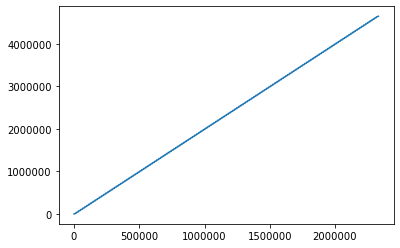

In [6]:
import matplotlib.pyplot as plt
plt.plot(sorted.values)

In [16]:
np.datetime64('2000-01-01T00:00:00')

numpy.datetime64('2000-01-01T00:00:00')

  Cloning https://github.com/pangeo-data/rechunker.git to /tmp/pip-t1v5fih0-build
    100% |████████████████████████████████| 135kB 1.3MB/s eta 0:00:01
    100% |████████████████████████████████| 737kB 535kB/s eta 0:00:01
    100% |████████████████████████████████| 3.9MB 117kB/s eta 0:00:01   4% |█▋                              | 192kB 18.3MB/s eta 0:00:01    93% |██████████████████████████████  | 3.7MB 18.0MB/s eta 0:00:01
    100% |████████████████████████████████| 786kB 501kB/s eta 0:00:01
    100% |████████████████████████████████| 5.2MB 101kB/s eta 0:00:01    84% |███████████████████████████▏    | 4.4MB 22.5MB/s eta 0:00:01
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-build-hyora3hr/pandas/setup.py", line 793, in <module>
        setup_package()
      File "/tmp/pip-build-hyora3hr/pandas/setup.py", line 763, in setup_package
        ext_modules=maybe_cythonize(exten

In [12]:
input_path = os.path.join(input_dir, '%s.0000000144.*.csv' % (float_file_prefix))
df = dd.read_csv(input_path, names=float_columns, header=0)
dfc = df.compute()
dfcs = dfc.sort_values('npart')

In [13]:
dfcs

,npart,time,x,y,z,u,v,t,s,eta
0,1,3600.0,-15.494134,-56.999610,-2.79,-0.063088,0.037052,-0.720748,33.873571,-1.342047
1,2,3600.0,-15.474018,-56.999165,-2.79,-0.078060,0.078221,-0.981074,33.863716,-1.328080
2,3,3600.0,-15.453284,-56.999266,-2.79,-0.080753,0.070169,-0.976164,33.864277,-1.327924
3,4,3600.0,-15.432540,-56.999206,-2.79,-0.079987,0.070343,-0.974665,33.863652,-1.327567
4,5,3600.0,-15.411922,-56.999272,-2.79,-0.082221,0.070048,-0.972591,33.862372,-1.327077
...,...,...,...,...,...,...,...,...,...,...
32395,4665596,3600.0,29.406248,-26.661935,-2.79,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
32396,4665597,3600.0,29.427082,-26.661751,-2.79,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
32397,4665598,3600.0,29.447916,-26.661748,-2.79,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
32398,4665599,3600.0,29.468748,-26.661913,-2.79,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000


In [11]:
input_dir

'/rigel/ocp/users/csj2114/swot/agulhas/run_1week_back'

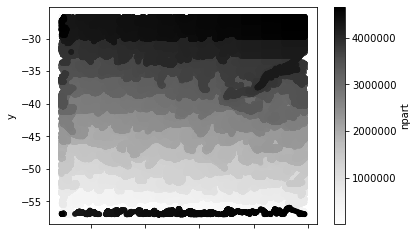

In [9]:
dfcs.plot.scatter(x='x',y='y',c='npart')